![Intro](https://i0.wp.com/www.careercontinuum.com/wp-content/uploads/2017/11/myersbriggs4.jpg?w=750&ssl=1)

# Introduction


The Myers-Briggs challenge requires the prediction of a 4 code designation representing personality type from posts and comments made by 8600 indivduals on the PersonalityCafe forum. The posts are a combination of personal texts as well as links visited and shared with others. 

The tested assumption is that a persons' choice of language and preference in specific types of social media activity can reflect their underlying psychological disposition.

The Myers-Briggs test classifies individuals into 1 of 16 personality types based on 4 contribtuting factors:
    1. Their degree of interaction with others and their surroundings, being either introverted (I) or extraverted (E).
    2. Their tendency to focus on objective, fact-based reality (S) or imaginative, subjective experience (N).
    3. Their tendency towards either logical (T) or emotional (F) behaviour.
    4. Their need for structure order (J) or for improvisation and flexibility (P).

The text will be manipulated according to natural language processing(NLP) norms. NLP is an attempt to decipher the vocabulary, syntax, grammar and ultimately the meaning of human speech in a way that can be interpreted by a computer.

Once the text has been sufficiently modified, predictions will be made using classification machine learning techniques. Classification is the process of predicting a particular class that categorical target variables can fall into (in this case personality type) based on a number of independent variables.
 
The following process will be followed to predict the MBTI types accordingly:

    1. EDA to understand the data.
    2. Cleaning and NLP preparation of text data for modelling.
    3. Fitting models and evaluating performance.

# Table of content
1. Import libraries
2. Import datasets
3. Data Preprocessing
    - 1. Resampling Data
    - 2. Feature Engineering
4. Exploratory Data Visualization
5. NLP data Preprocessing
    - 1. Tokenizing
    - 2. Stemming and Lemmatizing
6. NLP Feature Engineering
7. Missing Data
8. Feature Engineering
9. Fit Classification Models
10. Main Prediction

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
#from bs4 import BeautifulSoup
import requests
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import TreebankWordTokenizer, SnowballStemmer, pos_tag
import os
from sklearn.model_selection import GridSearchCV

# 2. Data Preprocessing

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

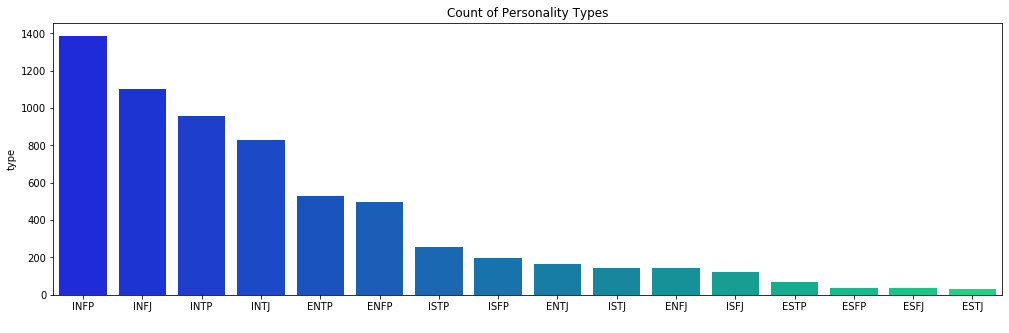

In [3]:
plt.figure(figsize=(17, 5))
plt.title("Count of Personality Types")
plt.xlabel(" ")
plt.ylabel(" ")
sns.barplot(train['type'].value_counts().index, train['type'].value_counts(),palette = 'winter')
plt.show()

Data not normally distrubuted across all personality types, we might consider resampling the data  (***upsample or downsample***).

### Resampling Data 


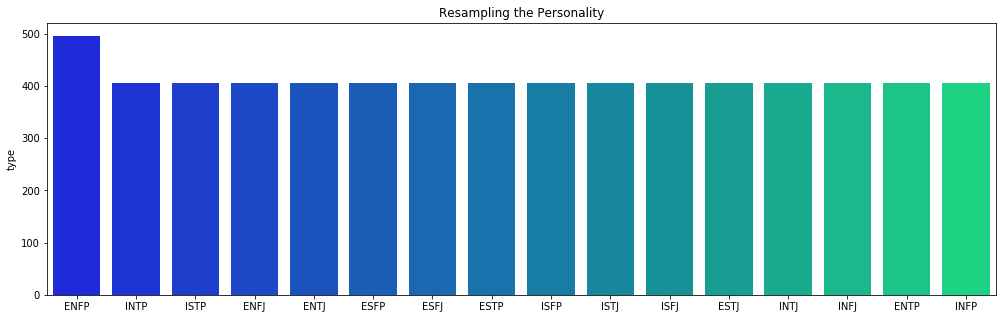

In [4]:
from sklearn.utils import resample
s = ['ENTJ', 'ENFJ','ESFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESTJ', 'ESFJ']
train_major = train[train['type'] == 'ENFP']
for a in s:
    train_min = train[train['type'] == a ]
    train_sam = resample(train_min ,replace = True, n_samples =  int(train['type'].value_counts().mean()),random_state = 123)
    train_major = pd.concat([train_major,train_sam])
    
t = ['INTJ','ENTP','INTP','INFP','INFJ'] 
for b in t :
    train_major_ds  = train[train['type'] == b ]
    train_sam = resample(train_major_ds ,replace = False, n_samples =  int(train['type'].value_counts().mean()),random_state = 123)
    train_major = pd.concat([train_major,train_sam])
    
# Upsampling

plt.figure(figsize=(17, 5))
plt.title("Resampling the Personality")
plt.xlabel(" ")
plt.ylabel(" ")
sns.barplot(train_major['type'].value_counts().index, train_major['type'].value_counts(),palette = 'winter')
plt.show()

The above visual shows how the data was resampled

###### Resampling data will not be considered going forward since it yield negative results

##### *Generating Classes*

In [3]:
# Mind class
train['Mind']   = train['type'].apply(lambda s : s[0])
train['Mind']   = train['Mind'].map({'I': 0,'E':1})

#Energy class
train['Energy'] = train['type'].apply(lambda s : s[1])
train['Energy'] = train['Energy'].map({'S': 0,'N':1})

#Nature
train['Nature'] = train['type'].apply(lambda s : s[2])                      
train['Nature'] = train['Nature'].map({'F': 0,'T':1})

#Tactic class
train['Tactic'] = train['type'].apply(lambda s : s[3])
train['Tactic'] = train['Tactic'].map({'P': 0,'J':1})

Creating classes : creating mind class based on  introvert or extrovert, Energy based on Sense and intuition, Nature based on feeling and thinkin and Tactic based perception and judge

##### Spliting texts in the posts column

In [4]:
#Split the train data
train['posts'] = train['posts'].apply(lambda s: ' '.join(s.split('|||')))
#split the test data
test['posts'] = test['posts'].apply(lambda s: ' '.join(s.split('|||')))

#### Find web links

In [5]:
train['number_of_links'] = train['posts'].str.count('http|https')

#### Find social media platform

In [6]:
train['social_media_presence'] = train['posts'].str.count('facebook.com|face.bo|twitter.com|instagram.com|tumblr.com')

#### Find videos

In [7]:
train['number_of_videos'] = train['posts'].str.count('youtube|vimeo|videobash')

#### Find blogs platforms

In [8]:
train['number_of_blogs'] = train['posts'].str.count('blog|wordpress')

#### Find images and documents

In [9]:
d = ('.png.|.jpg.|.gif|.tiff|.psd|.raw|.indd|.pdf|tinypic|.imageshack|')
train['number_of_images'] = train['posts'].str.count(d)

In [10]:
train.head()

,type,posts,Mind,Energy,Nature,Tactic,number_of_links,social_media_presence,number_of_videos,number_of_blogs,number_of_images
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525
1,ENTP,'I'm finding the lack of me in these posts ver...,1,1,1,0,10,1,1,0,6914
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,1,1,0,5,2,3,1,5165
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,1,1,1,2,0,2,0,6174
4,ENTJ,'You're fired. That's another silly misconcept...,1,1,1,1,6,0,1,0,6006


In [11]:
train_presentation = train.drop('posts', axis = 1)

In [12]:
train_presentation.head()

,type,Mind,Energy,Nature,Tactic,number_of_links,social_media_presence,number_of_videos,number_of_blogs,number_of_images
0,INFJ,0,1,0,1,24,1,17,0,4525
1,ENTP,1,1,1,0,10,1,1,0,6914
2,INTP,0,1,1,0,5,2,3,1,5165
3,INTJ,0,1,1,1,2,0,2,0,6174
4,ENTJ,1,1,1,1,6,0,1,0,6006


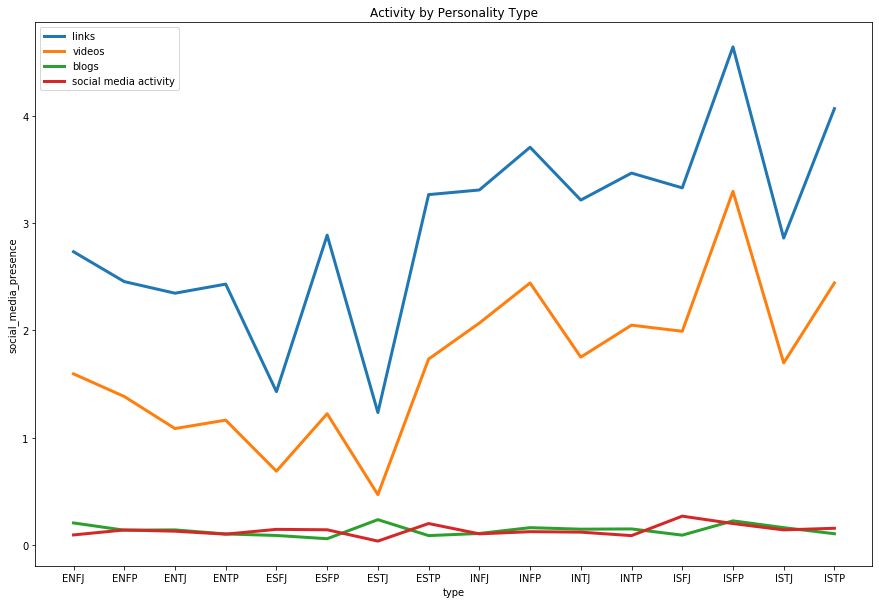

In [13]:
plt.figure(figsize = (15,10))
plt.title("Activity by Personality Type")
plt.xlabel("Personality Type")
plt.ylabel("Count")
sns.lineplot(x='type', y='number_of_links', data=train_presentation, ci=None, label='links', linewidth=3)
sns.lineplot(x='type', y='number_of_videos', data=train_presentation, ci=None, label='videos', linewidth=3)
sns.lineplot(x='type', y='number_of_blogs', data=train, ci=None, label='blogs', linewidth=3)
#sns.lineplot(x='type', y='number_of_images', data=train)
sns.lineplot(x='type', y='social_media_presence', data=train, ci=None, label='social media activity', linewidth=3)
plt.savefig('presentationfig_1.png')

In [14]:
sales = pd.read_csv('OnlineRetail.csv', encoding = "ISO-8859-1")

In [15]:
sales_type = train['type'].unique()

In [16]:
print(random.choice(sales_type))

INTP


In [17]:
sales_type2 = []
for i in range(len(sales)):
    sales_type2.append(random.choice(sales_type))

In [18]:
for i in range(10):
    print(sales_type2[i])

ENTP
ESTP
ESTJ
ISFJ
ESTP
ENFP
ESFJ
ENTP
ISFP
ISTJ


In [19]:
sales['type'] = sales_type2

In [20]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,ENTP
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,ESTP
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,ESTJ
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,ISFJ
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,ESTP


In [32]:
train_small = train.iloc[0:1000, :]
sales_small = sales.iloc[0:1000, :]

In [33]:
train_small.head()

,type,posts,Mind,Energy,Nature,Tactic,number_of_links,social_media_presence,number_of_videos,number_of_blogs,number_of_images
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525
1,ENTP,'I'm finding the lack of me in these posts ver...,1,1,1,0,10,1,1,0,6914
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,1,1,0,5,2,3,1,5165
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,1,1,1,2,0,2,0,6174
4,ENTJ,'You're fired. That's another silly misconcept...,1,1,1,1,6,0,1,0,6006


In [34]:
personality_sales = train_small.merge(sales_small, on='type', how='inner')

In [37]:
personality_sales.head()

,type,posts,Mind,Energy,Nature,Tactic,number_of_links,social_media_presence,number_of_videos,number_of_blogs,number_of_images,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/2010 8:45,0.85,12583.0,France
1,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536372,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 9:01,1.85,17850.0,United Kingdom
2,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536373,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 9:02,7.65,17850.0,United Kingdom
3,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536376,22114,HOT WATER BOTTLE TEA AND SYMPATHY,48,12/1/2010 9:32,3.45,15291.0,United Kingdom
4,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536377,22633,HAND WARMER UNION JACK,6,12/1/2010 9:34,1.85,17850.0,United Kingdom


In [42]:
personality_sales['Description'].nunique()

591

In [49]:
product_type = personality_sales['Description'].unique()

In [102]:
product_type_dict = dict(enumerate(product_type))
product_type_dict = dict((v,k) for k,v in product_type_dict.items())

In [104]:
personality_sales['ProductType'] = personality_sales['Description'].map(product_type_dict)

In [105]:
personality_sales.head()

,type,posts,Mind,Energy,Nature,Tactic,number_of_links,social_media_presence,number_of_videos,number_of_blogs,number_of_images,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ProductType
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/2010 8:45,0.85,12583.0,France,0
1,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536372,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 9:01,1.85,17850.0,United Kingdom,1
2,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536373,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 9:02,7.65,17850.0,United Kingdom,2
3,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536376,22114,HOT WATER BOTTLE TEA AND SYMPATHY,48,12/1/2010 9:32,3.45,15291.0,United Kingdom,3
4,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,0,1,0,1,24,1,17,0,4525,536377,22633,HAND WARMER UNION JACK,6,12/1/2010 9:34,1.85,17850.0,United Kingdom,4


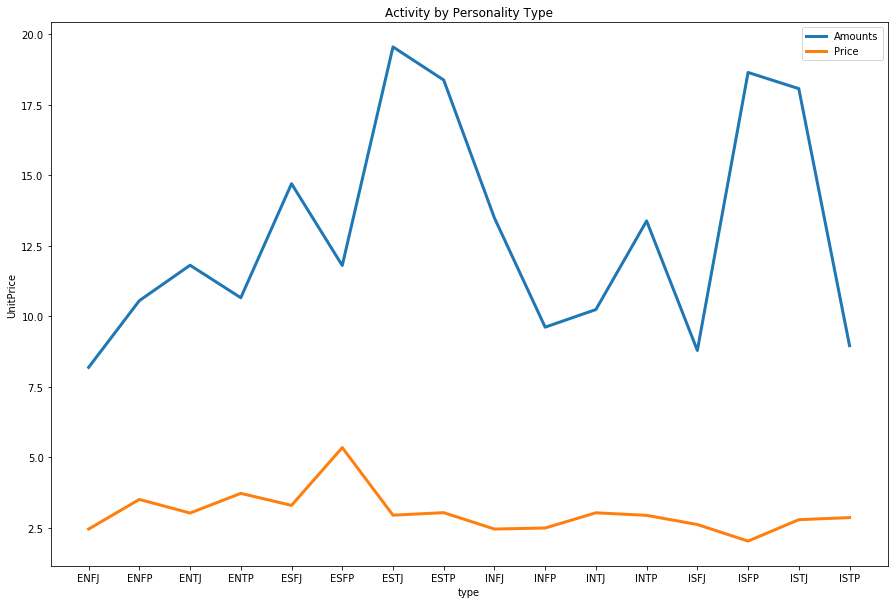

In [111]:
plt.figure(figsize = (15,10))
plt.title("Activity by Personality Type")
plt.xlabel("Personality Type")
plt.ylabel("Count")
sns.lineplot(x='type', y='Quantity', data=personality_sales, ci=None, label='Amounts', linewidth=3)
sns.lineplot(x='type', y='UnitPrice', data=personality_sales, ci=None, label='Price', linewidth=3)
#sns.lineplot(x='type', y='ProductType', data=personality_sales, ci=None, label='Product', linewidth=3)
plt.show()

# 3. Exploratory Data Visualization

#### Find images and documents

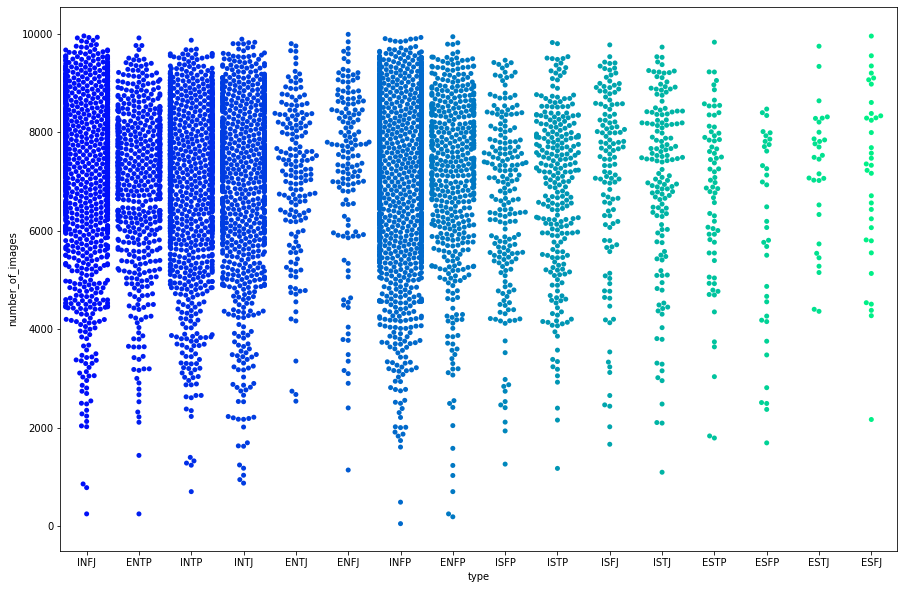

In [12]:
plt.figure(figsize = (15,10))
sns.swarmplot('type','number_of_images', data = train,palette = 'winter')

#### Social Media

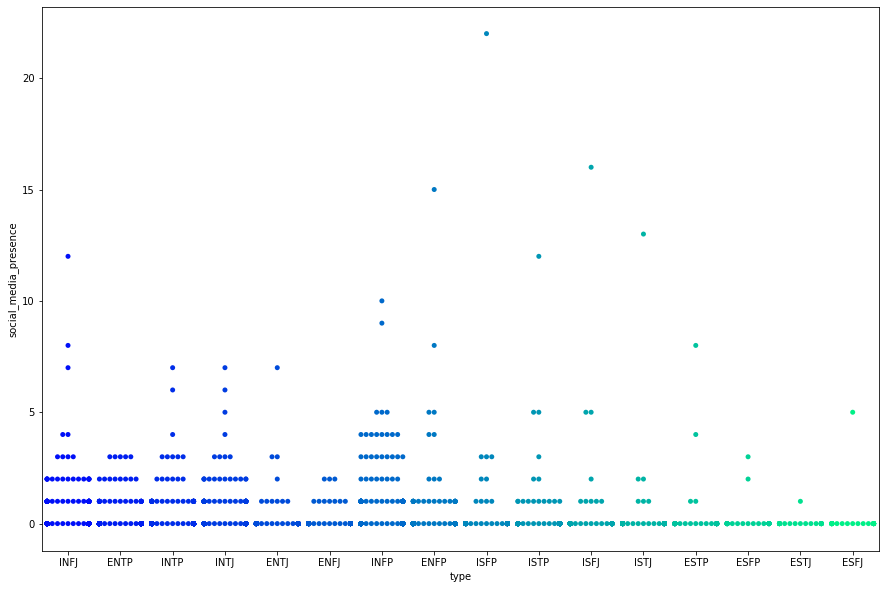

In [13]:
plt.figure(figsize = (15,10))
sns.swarmplot('type','social_media_presence', data = train,palette = 'winter')

### Number of video links

In [ ]:
plt.figure(figsize = (15,10))
sns.swarmplot('type','number_of_videos', data = train,palette = 'winter')

####  Number of blogs

In [ ]:
plt.figure(figsize = (15,10))
sns.swarmplot('type','number_of_blogs', data = train,palette = 'winter')

### Number of links

In [ ]:
plt.figure(figsize = (15,12))
sns.swarmplot('type','number_of_links', data = train,palette = 'winter')

![NLP](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9hkA2TL95UvxuNBOj5t_olTilEKeuri7OG5acD-jq4pLvI_fUFQ)

### NLP data Preprocessing

In [ ]:
train['posts'] = train['posts'].apply(lambda b : ''.join([ 'Photos' if s.endswith(d) else s for s in b]))
test['posts'] = test['posts'].apply(lambda b : ''.join([ 'photos' if s.endswith(d) else s for s in b]))

In [ ]:
# Replace Web links
train['posts'] = train['posts'].apply(lambda s : ''.join([re.sub(r'http\S+', r'link', s)]))
test['posts'] = test['posts'].apply(lambda s : ''.join([re.sub(r'http\S+', r'link', s)]))

In [ ]:
train['posts'] = train['posts'].apply(lambda s: ' '.join(s.split('::')))
train['posts'] = train['posts'].apply(lambda s: ' '.join(s.split('-')))

test['posts'] = test['posts'].apply(lambda s: ' '.join(s.split('::')))
test['posts'] = test['posts'].apply(lambda s: ' '.join(s.split('-')))

1. Keeping only the words with length greater than 3 in the following code for removing small
    words which hardly consists of much of a meaning to carry;
    
2. Stemming applied on the words using Porter stemmer which stems the extra suffixes from
    the words
    
3. POS tagging is a prerequisite for lemmatization, based on whether word is noun or verb or
    and so on. it will reduce it to the root word
   
4. pos_tag function returns the part of speed in four formats for Noun and six formats for
    verb. NN - (noun, common, singular), NNP - (noun, proper, singular), NNPS - (noun,
    proper, plural), NNS - (noun, common, plural), VB - (verb, base form), VBD - (verb, past
    tense), VBG - (verb, present participle), VBN - (verb, past participle), VBP - (verb, present
    tense, not 3rd person singular), VBZ - (verb, present tense, third person singular)

5. The following function, prat_lemmatize, has been created only for the reasons of
    mismatch between the pos_tag function and intake values of lemmatize function. If the
    tag for any word falls under the respective noun or verb tags category, n or v will be
    applied accordingly in lemmatize function:

#### Stem and lematize

Stemming is a normalization process that involves reducing a word to its root form. for example, the root word for the following words "programs,pogramer programing programers"is program.
Stemming is desirable as it may reduce redundancy as most of the time the word stem and their inflected/derived words mean the same.

Source:https://www.geeksforgeeks.org/python-stemming-words-with-nltk/


Lemmatization is the process of converting a word to its base form. Unlike stemming, 
lemmatization considers the context and converts the word to its meaningful base form

Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [ ]:
def preprocessing(text):
    text2 = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())
    text2 = " ".join("".join([" " if ch in string.digits else ch for ch in text]).split())
    tokens = [word for sent in nltk.sent_tokenize(text2) for word in nltk.word_tokenize(sent)]
    tokens = [word.lower() for word in tokens]
    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]
    tokens = [word for word in tokens if len(word)>=3]
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    tagged_corpus = pos_tag(tokens)
    Noun_tags = ['NN','NNP','NNPS','NNS']
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']
    lemmatizer = WordNetLemmatizer()
    def prat_lemmatize(token,tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token,'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token,'v')
        else:
            return lemmatizer.lemmatize(token,'n')
    pre_proc_text = " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])
    return pre_proc_text

In [ ]:
train.posts = train.posts.apply(preprocessing)
test.posts = test.posts.apply(preprocessing)

In [ ]:
intro = ['INFJ', 'INTP', 'INTJ', 'INFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ']

for i in range(1, 9):
    for a in intro:
        plt.figure(figsize=(12, 8))
        
        df_intro = train[train.type == a]
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_intro))
        plt.title(a)
        plt.imshow(wordcloud, interpolation='bilinear', aspect='equal')
        plt.axis("off")
        plt.show()
    break

In [ ]:
entro = ['ENFJ', 'ENTP', 'ENTJ', 'ENFP', 'ESFP', 'ESTP', 'ESFJ', 'ESTJ']

for i in range(1, 9):
    for a in entro:
        plt.figure(figsize=(12, 8))
        
        df_entro = train[train.type == a]
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_entro))
        plt.title(a)
        plt.imshow(wordcloud, interpolation='bilinear', aspect='equal')
        plt.axis("off")
        plt.show()
    break

In [ ]:
train.head()

# NLP Feature Engineering
Under feature_extraction.text class we import TfidfVectorizer and Countvectorizer

#### TfidfVectorizer (TF-IDF):
Term Frequent-Inverse Data Frequency, Term Frequent : gives us the frequency of the word in each document in the corpus. It is the ratio of number of time the word appears in a document compared to the total number of words in that document.It increases as the number of occurrences of that word within the documnents increase. {formula}. IDF : used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score.{formula}

In [ ]:
# tfidvect_sub = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.7)#, min_df=0.05)
# X_train_tfidvect_sub = tfidvect_sub.fit_transform(train['stem'])
# X_test_tfidvect_sub = tfidvect_sub.transform(test['stem'])

In [ ]:
train.head(n=1)

In [ ]:
# Importing TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Instatiating TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(max_df= 0.7,stop_words='english')
# Fit transform
X_tfi = tfidfvectorizer.fit_transform(train['posts'])
# Setting the four classes
y_mind = train['Mind']
y_enegry = train['Energy']
y_nature = train['Nature']
y_tactic = train['Tactic']

#### CountVectorizer
Every column is term from the corpus and, evry cell represents the frequency count of a term in each document. {formula}

In [ ]:
# Importing CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Instatiating CountVectorizer
countvectorizer = CountVectorizer(max_df= 0.7,stop_words='english')
# Fit transform
X_countvectorizer = countvectorizer.fit_transform(train['posts'])

# Fit Classification Models

#### Logistic Regression 
Logistic Regression is used when the dependent variable is categorical. Types of Logistic Regression : 1. Binary Logistic Regression 2. Multinomial Logistic Regression 3. Ordinal Logistic Regression.

Since we are modelling the probability, $P(X)$ should be greater or equal to 0 and smaller or equal to 1 for it to make sense. We therefore require a function that gives outputs between 0 and 1 for all input values of $X$. For this we use the **logistic function** displayed graphical below:

<img src="https://github.com/Samantha-movius/hello-world/blob/master/logistic_reg.png?raw=true" alt="Drawing" style="width: 500px;"/>

Which is defined by the function:

$$P(X) = \displaystyle \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}}$$

After a bit of manipulation we arrive at:

\begin{align}
1 - P(X) &= \displaystyle \frac{1}{1+e^{\beta_0 + \beta_1 X}} \\
\therefore \log \left( \frac{P(X)}{1-P(X)} \right) &= {\beta_0 + \beta_1 X}
\end{align}

So the fraction on the left is being modelled as a linear function of the observations $X$, and this is known as the **log odds ratio**. Without the log sign in front of it, it is known simply as the odds ratio. While $P(X)$ is bounded between 0 and 1, the odds ratio is bounded between 0 and $\infty$. 

###  Instatiating Logistic regressor and MultinomialNB
Get the parameters

In [ ]:
logistic_reg = LogisticRegression()
nbayes = MultinomialNB()
print('logistic Regression Parameters: ', logistic_reg.get_params())
print()
print('MultinomialNB: ', nbayes.get_params())

### Instantiating GridSearchCV
hyperparameter tuning refers to choosing a set of optimal hyperparameters for a machine learning algorithm. 
Grid search is a common tuning Strategy used to perform hyperparameter optimization. It works by searching exhaustively through a specified subset of hyperparameters.
The benefit of grid search is that it is guaranteed to find the optimal combination of parameters supplied.

Source: https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624

In [ ]:
# Instantiate the GridSearchCV for Logistic Regression
logr_parameters = {'penalty' : ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10],'class_weight': [None, 'balanced']}
gscv_log = GridSearchCV(logistic_reg,logr_parameters)
# Instantiate the GridSearchCV for MultinomialNB
nbayes_parameters = {'alpha' : [0.1, 1, 0.1]}
gscv_naive = GridSearchCV(nbayes,nbayes_parameters)

### Energy class

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_enegry, test_size = 0.30,random_state = 0)

#### Base model

In [ ]:
# LOGISTIC REGRESSION
logistic_reg.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg.score(X_train,y_train))
y_p = logistic_reg.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# MULTINOMIALND
nbayes.fit(X_train,y_train)
# Evaluating Performance
print('Train score Random Forest ',nbayes.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

#### Train with parameters

In [ ]:
# LOGISTIC REGRESSION
gscv_log.fit(X_train,y_train) 
print('Logr Train score :',gscv_log.score(X_train,y_train))
y_p = gscv_log.predict(X_test)
print('Logr Accuracy :',accuracy_score(y_test,y_p))
print('Logr Best Parameters: ', gscv_log.best_params_)

# MUILTINOMILNB
gscv_naive.fit(X_train,y_train) 
print('nbayes Train score :',gscv_naive.score(X_train,y_train))
y_p = gscv_naive.predict(X_test)
print('nbayes Accuracy :',accuracy_score(y_test,y_p))
print('nbayes Best Parameters: ', gscv_naive.best_params_)

#### Train , Test and Evaluate with best parameters

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_enegry, test_size = 0.30,random_state = 0)
# fitting the regressor
logistic_reg_tuned_E = LogisticRegression(penalty='l2', class_weight = 'balanced', C=1)
logistic_reg_tuned_E.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg_tuned_E.score(X_train,y_train))
y_p = logistic_reg_tuned_E.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# fitting the random forest
nbayes_tuned = MultinomialNB(alpha=1)
nbayes_tuned.fit(X_train,y_train)
# Evaluating Performance
print( 'Train score Random Forest ',nbayes_tuned.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

### Mind class

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_mind, test_size = 0.30,random_state = 0)

#### Base Model

In [ ]:
# LOGISTIC REGRESSION
logistic_reg.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg.score(X_train,y_train))
y_p = logistic_reg.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# MULTINOMIALND
nbayes.fit(X_train,y_train)
# Evaluating Performance
print('Train score Random Forest ',nbayes.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

#### Train with parameters

In [ ]:
# LOGISTIC REGRESSION
gscv_log.fit(X_train,y_train) 
print('Logr Train score :',gscv_log.score(X_train,y_train))
y_p = gscv_log.predict(X_test)
print('Logr Accuracy :',accuracy_score(y_test,y_p))
print('Logr Best Parameters: ', gscv_log.best_params_)

# MUILTINOMILNB
gscv_naive.fit(X_train,y_train) 
print('nbayes Train score :',gscv_naive.score(X_train,y_train))
y_p = gscv_naive.predict(X_test)
print('nbayes Accuracy :',accuracy_score(y_test,y_p))
print('nbayes Best Parameters: ', gscv_naive.best_params_)

#### Train , Test and Evaluate with best parameters

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_mind, test_size = 0.30,random_state = 0)
# fitting the regressor
logistic_reg_tuned_M = LogisticRegression(penalty='l2',class_weight ='balanced', C=10)
logistic_reg_tuned_M.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg_tuned_M.score(X_train,y_train))
y_p = logistic_reg_tuned_M.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# fitting the random forest
nbayes_tuned = MultinomialNB(alpha=1)
nbayes_tuned.fit(X_train,y_train)
# Evaluating Performance
print( 'Train score Random Forest ',nbayes_tuned.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

### Nature Class

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_nature, test_size = 0.30,random_state = 0)

#### Base model

In [ ]:
# LOGISTIC REGRESSION
logistic_reg.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg.score(X_train,y_train))
y_p = logistic_reg.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# MULTINOMIALND
nbayes.fit(X_train,y_train)
# Evaluating Performance
print('Train score Random Forest ',nbayes.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

#### Train with parameters

In [ ]:
# LOGISTIC REGRESSION
gscv_log.fit(X_train,y_train) 
print('Logr Train score :',gscv_log.score(X_train,y_train))
y_p = gscv_log.predict(X_test)
print('Logr Accuracy :',accuracy_score(y_test,y_p))
print('Logr Best Parameters: ', gscv_log.best_params_)

# MUILTINOMILNB
gscv_naive.fit(X_train,y_train) 
print('nbayes Train score :',gscv_naive.score(X_train,y_train))
y_p = gscv_naive.predict(X_test)
print('nbayes Accuracy :',accuracy_score(y_test,y_p))
print('nbayes Best Parameters: ', gscv_naive.best_params_)

#### Train , Test and Evaluate with best parameters

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_nature, test_size = 0.30,random_state = 0)
# fitting the regressor
logistic_reg_tuned_N = LogisticRegression(penalty='l2',class_weight = 'balanced' , C=10)
logistic_reg_tuned_N.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg_tuned_N.score(X_train,y_train))
y_p = logistic_reg_tuned_N.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# fitting the random forest
nbayes_tuned = MultinomialNB(alpha=1)
nbayes_tuned.fit(X_train,y_train)
# Evaluating Performance
print( 'Train score Random Forest ',nbayes_tuned.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

### Tactic Class

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_tactic, test_size = 0.30,random_state = 0)

#### Base Model

In [ ]:
# LOGISTIC REGRESSION
logistic_reg.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg.score(X_train,y_train))
y_p = logistic_reg.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# MULTINOMIALND
nbayes.fit(X_train,y_train)
# Evaluating Performance
print('Train score Random Forest ',nbayes.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

#### Train with parameters

In [ ]:
# LOGISTIC REGRESSION
gscv_log.fit(X_train,y_train) 
print('Logr Train score :',gscv_log.score(X_train,y_train))
y_p = gscv_log.predict(X_test)
print('Logr Accuracy :',accuracy_score(y_test,y_p))
print('Logr Best Parameters: ', gscv_log.best_params_)

# MUILTINOMILNB
gscv_naive.fit(X_train,y_train) 
print('nbayes Train score :',gscv_naive.score(X_train,y_train))
y_p = gscv_naive.predict(X_test)
print('nbayes Accuracy :',accuracy_score(y_test,y_p))
print('nbayes Best Parameters: ', gscv_naive.best_params_)

#### Train , Test and Evaluate with best parameters

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_tfi,y_tactic, test_size = 0.30,random_state = 0)
# fitting the regressor
logistic_reg_tuned_T = LogisticRegression(penalty='l2', class_weight = 'balanced', C=1)
logistic_reg_tuned_T.fit(X_train,y_train) 
# Evaluating Performance
print( 'Train score Logistic Regression ',logistic_reg_tuned_T.score(X_train,y_train))
y_p = logistic_reg_tuned_T.predict(X_test)
print('Logr Classification Report: ', classification_report(y_test,y_p))

# fitting the random forest
nbayes_tuned = MultinomialNB(alpha=1)
nbayes_tuned.fit(X_train,y_train)
# Evaluating Performance
print( 'Train score Random Forest ',nbayes_tuned.score(X_train,y_train))
y_p = nbayes.predict(X_test)
print('RF Classification Report: ', classification_report(y_test,y_p))

# Main Prediction

In [ ]:
logistic_reg = LogisticRegression(class_weight = 'balanced', )

In [ ]:
# Main Prediction
X_test_m = tfidfvectorizer.transform(test['posts'])
# Mind
logistic_reg.fit(X_tfi,y_mind)
y_mind_pred = logistic_reg.predict(X_test_m)

In [ ]:
# Main Prediction

# Energy
logistic_reg.fit(X_tfi,y_enegry)
y_energy_pred = logistic_reg.predict(X_test_m)

In [ ]:
# Main Prediction

# Tactics
logistic_reg.fit(X_tfi,y_tactic)
y_tactic_pred = logistic_reg.predict(X_test_m)

In [ ]:
#Main Prediction
# Nature
logistic_reg.fit(X_tfi,y_nature)
y_nature_pred = logistic_reg.predict(X_test_m)

In [ ]:
df = pd.DataFrame({'Id':test['id'],'mind':y_mind_pred,'energy':y_energy_pred,'nature':y_nature_pred,'tactics':y_tactic_pred})

df.to_csv('out_csv.csv',index = False)

# Conclusion

Text data for 8600 individuals, as well as each of their MBTI designations was scraped from the PersonalityCafe forum, followed by several attempts to manipulate the data according to natural language processing rules and norms.

Initially, the independent 'type' column was split into 4 sub-classes: 'mind', 'nature', 'energy' and 'tactics' to sub-divide the classification system into its' individual components and allow for model predictions to be based on binary target variable classification.

This allowed for more detailed prediction of the underlying psychological conditions as well as lowering computational time and resource requirements.  

Data was then stemmed and lemmatized and passed to a tfidVectorizer to calculate the frequency of words in each document in relation to the total corpus. 

Predictions were then performed using both a logistic regression model and multinomial Naive Bayes, and hyperparamater tuning was performed for both models. Using this approach, we conclude that a base logistic regression model using default paramaters was able to provide the most accurate prediction of personality type.